In [54]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate

from astropy.io import fits, ascii
from astropy.table import Table,join
from astropy.table import vstack as vstack_table

from lvmdap.dap_tools import list_columns,read_DAP_file,map_plot_DAP
from matplotlib import use as mpl_use
#mpl_use('Agg')
import sys
org_stdout = sys.stdout # Save a reference to the original standard output

import math
from IPython.display import display, HTML
%matplotlib inline
from matplotlib import rcParams as rc
rc.update({'font.size': 19,\
           'font.weight': 900,\
           'text.usetex': True,\
           'path.simplify'           :   True,\
           'xtick.labelsize' : 19,\
           'ytick.labelsize' : 19,\
#           'xtick.major.size' : 3.5,\
#           'ytick.major.size' : 3.5,\
           'axes.linewidth'  : 2.0,\
               # Increase the tick-mark lengths (defaults are 4 and 2)
           'xtick.major.size'        :   6,\
           'ytick.major.size'        :   6,\
           'xtick.minor.size'        :   3,\
           'ytick.minor.size'        :   3,\
           'xtick.major.width'       :   1,\
           'ytick.major.width'       :   1,\
           'lines.markeredgewidth'   :   1,\
           'legend.numpoints'        :   1,\
           'xtick.minor.width'       :   1,\
           'ytick.minor.width'       :   1,\
           'legend.frameon'          :   False,\
           'legend.handletextpad'    :   0.3,\
           'font.family'    :   'serif',\
           'mathtext.fontset'        :   'stix',\
           'axes.facecolor' : "w",\
           
          })


In [55]:
def tab_cols(tab_DAP):
    cols=[]
    for each in tab_DAP.columns:
        cols.append(each)
    cols=np.array(cols)
    return cols

def astropy_table_to_html_columns(table, cols=4, caption=None):
    """
    Generate an HTML table for the given Astropy Table with evenly-spaced columns.

    Parameters
    ----------
    table : astropy.table.Table
        The Astropy Table to be converted.
    cols : int, optional
        The number of columns in which the table should be printed.
    """
    html_table = "<div style='height: 200px; overflow: auto;'><table>"
    if (caption != None):
        html_table += f'<caption>{caption}</caption>'

    # Add column headers
    html_table += "<tr>"
    for i in np.arange(cols):
        for col in table.colnames:
            html_table += f"<th>{col}</th>"
    html_table += "</tr>"

    # Add rows
    for i in range(0, len(table), cols):
        html_table += "<tr>"
        for row in table[i:i + cols]:
            for value in row:
                html_table += f"<td>{value}</td>"
        # Add empty cells if necessary to complete the row
        empty_cells = (cols - len(row)) if len(row) < cols else 0
        html_table += f"<td colspan='{empty_cells * 2}'></td>" * empty_cells
        html_table += "</tr>"

    html_table += "</table></div>"
    return html_table



def list_columns_to_html(obj, cols=4, columnwise=True, gap=2, caption=None):
    """
    Generate an HTML table for the given list with evenly-spaced columns.

    Parameters
    ----------
    obj : list
        The list to be printed.
    cols : int
        The number of columns in which the list should be printed.
    columnwise : bool, default=True
        If True, the items in the list will be printed column-wise.
        If False, the items in the list will be printed row-wise.
    gap : int
        The number of spaces that should separate the longest column
        item/s from the next column. This is the effective spacing
        between columns based on the maximum len() of the list items.
    """

    sobj = [str(item) for item in obj]
    if cols > len(sobj): cols = len(sobj)
    max_len = max([len(item) for item in sobj])
    if columnwise: cols = int(math.ceil(float(len(sobj)) / float(cols)))
    plist = [sobj[i: i+cols] for i in range(0, len(sobj), cols)]
    if columnwise:
        if not len(plist[-1]) == cols:
            plist[-1].extend(['']*(len(sobj) - len(plist[-1])))
        plist = list(map(list, zip(*plist)))

    # Generate HTML table
    html_table = "<table>"
    if (caption != None):
        html_table += f'<caption>{caption}</caption>'
    for row in plist:
        html_table += "<tr>"
        for col in row:
            html_table += f"<td>{col}</td>"
        html_table += "</tr>"
    html_table += "</table>"
    
    return html_table


In [62]:
def read_DAP_file_model(dap_file,dap_desc=None,verbose=False,template='html_DM_template.html'):    
    dap_hdu=fits.open(dap_file)
    tab_PT=Table(dap_hdu['PT'].data)
    tab_RSP=Table(dap_hdu['RSP'].data)
    tab_COEFFS=Table(dap_hdu['COEFFS'].data)
    tab_PE=Table(dap_hdu['PM_ELINES'].data)
    tab_NPE_B=Table(dap_hdu['NP_ELINES_B'].data)
    tab_NPE_R=Table(dap_hdu['NP_ELINES_R'].data)
    tab_NPE_I=Table(dap_hdu['NP_ELINES_I'].data)
    tab_info=Table(dap_hdu['INFO'].data)
    

    
    #
    
    #tab_hdu=Table(dap_hdu.info())
    #print(tab_hdu.columns)
    #
    #print(tabulate(dap_hdu.info(), tablefmt='html'))
    

#    print(tab_PT_cols)
    

    #
    # Rename some entries!
    #
    tab_RSP.rename_column('Av','Av_st')
    tab_RSP.rename_column('e_Av','e_Av_st')
    tab_RSP.rename_column('z','z_st')
    tab_RSP.rename_column('e_z','e_z_st')
    tab_RSP.rename_column('disp','disp_st')
    tab_RSP.rename_column('e_disp','e_disp_st')
    tab_RSP.rename_column('flux','flux_st')
    tab_RSP.rename_column('redshift','redshift_st')
    tab_RSP.rename_column('med_flux','med_flux_st')
    tab_RSP.rename_column('e_med_flux','e_med_flux_st')
    tab_RSP.rename_column('sys_vel','vel_st')
    #
    # Parametric elines
    #
    tab_PE.rename_column('flux','flux_pe')
    tab_PE.rename_column('e_flux','e_flux_pe')
    tab_PE.rename_column('disp','disp_pe')
    tab_PE.rename_column('e_disp','e_disp_pe')
    tab_PE.rename_column('vel','vel_pe')
    tab_PE.rename_column('e_vel','e_vel_pe')
    #
    # id	id_fib	rsp	TEFF	LOGG	META	ALPHAM	COEFF	Min.Coeff	log(M/L)	AV	N.Coeff	Err.Coeff
    #
    tab_COEFFS.rename_column('rsp','id_rsp')
    tab_COEFFS.rename_column('TEFF','Teff_rsp')
    tab_COEFFS.rename_column('LOGG','Log_g_rsp')
    tab_COEFFS.rename_column('META','Fe_rsp')
    tab_COEFFS.rename_column('ALPHAM','alpha_rsp')
    tab_COEFFS.rename_column('COEFF','W_rsp')
    tab_COEFFS.rename_column('Min.Coeff','min_W_rsp')
    tab_COEFFS.rename_column('log(M/L)','log_ML_rsp')
    tab_COEFFS.rename_column('AV','Av_rsp')
    tab_COEFFS.rename_column('N.Coeff','n_W_rsp')
    tab_COEFFS.rename_column('Err.Coeff','e_W_rsp')
    
    
#    t_cols=(tab_cols(tab_PT),tab_cols(tab_RSP),tab_cols(tab_COEFFS),\
#              tab_cols(tab_PE),\
#              tab_cols(tab_NPE_B),tab_cols(tab_NPE_R),tab_cols(tab_NPE_I),\
#              tab_cols(tab_info))

    t_cols=(tab_PT,tab_RSP,tab_COEFFS,\
              tab_PE,\
              tab_NPE_B,tab_NPE_R,tab_NPE_I,\
              tab_info)
    
    
    tab_DAP=Table(dap_hdu['PT'].data)
    tab_DAP=join(tab_DAP,tab_RSP,keys=['id'],join_type='left')
    tab_DAP=join(tab_DAP,tab_NPE_B,keys=['id'],join_type='left')
    tab_DAP=join(tab_DAP,tab_NPE_R,keys=['id'],join_type='left')
    tab_DAP=join(tab_DAP,tab_NPE_I,keys=['id'],join_type='left')

    #
    # order parametric emission line table
    #
    a_wl = np.unique(tab_PE['wl'])
    I=0
    for wl_now in a_wl:
        if (wl_now>0.0):
            tab_PE_now=tab_PE[tab_PE['wl']==wl_now]
            tab_PE_tmp=tab_PE_now['id','flux_pe','e_flux_pe','disp_pe','e_disp_pe','vel_pe','e_vel_pe']
            for cols in tab_PE_tmp.colnames:        
                if (cols != 'id'):
                    tab_PE_tmp.rename_column(cols,f'{cols}_{wl_now}')
            if (I==0):
                tab_PE_ord=tab_PE_tmp
            else:
                tab_PE_ord=join(tab_PE_ord,tab_PE_tmp,keys=['id'],join_type='left')
            I=I+1
    tab_DAP=join(tab_DAP,tab_PE_ord,keys=['id'],join_type='left')

    #
    # Order COEFFS table
    #
    a_rsp=np.unique(tab_COEFFS['id_rsp'])
    for I,rsp_now in enumerate(a_rsp):
        tab_C_now=tab_COEFFS[tab_COEFFS['id_rsp']==rsp_now]
        tab_C_tmp=tab_C_now['id','Teff_rsp', 'Log_g_rsp', 'Fe_rsp',\
                            'alpha_rsp', 'W_rsp', 'min_W_rsp',\
                            'log_ML_rsp', 'Av_rsp', 'n_W_rsp', 'e_W_rsp']
        for cols in tab_C_tmp.colnames:        
            if (cols != 'id'):
                tab_C_tmp.rename_column(cols,f'{cols}_{rsp_now}')
        if (I==0):
            tab_C_ord=tab_C_tmp
        else:
            tab_C_ord=join(tab_C_ord,tab_C_tmp,keys=['id'],join_type='left')
    tab_DAP=join(tab_DAP,tab_C_ord,keys=['id'],join_type='left')

    
    if ((verbose==True) and (dap_desc != None)):
        f_temp = open('DAP_hdu.txt', 'r')
        Lines_hdu = f_temp.readlines()                
        f_temp.close()
        
        f_temp = open(template, 'r')
        Lines = f_temp.readlines()
        f_temp.close()
        for line in Lines:
#            print('find: ',line.find('DM_'))
            if (line.find('DM_')>-1):
                xline=line.replace('DM_FILE',dap_desc['file'])
                xline=xline.replace('DM_DESC',dap_desc['desc'])
                xline=xline.replace('DM_CONV',dap_desc['conv'])
                xline=xline.replace('DM_SIZE',dap_desc['size'])
            else:
                xline=line
            if (line.find('DM_SECTIONS')>-1):
                print('<dt>Sections</dt>')
                print('<dd>')
                print('<ul>')             
                for c_hdu,line_hdu in enumerate(Lines_hdu):
                    if (c_hdu>1):
                        a_line_hdu=line_hdu.split()
                        #                        print('a_line = ',a_line_hdu[0])
                        try:                 
                            key='hdu'+str(int(a_line_hdu[0]))
                            u_key=key.upper()
                            desc_now=dap_desc[key]
                            print(f'<li><a href="#{key}">{u_key}: {a_line_hdu[1]}</a> {desc_now}</li>')
                        except:
                            val_now=None
                desc_now=dap_desc['tab_dap']
                print(f'<li><a href="#tab_dap"> TAB_DAP</a> {desc_now}</li>')
                print('</ul>')
                print('</dd>')
                xline=''
            if (line.find('DM_HEADERS')>-1):
                xline=''
                for c_hdu,line_hdu in enumerate(Lines_hdu):
                    a_line_hdu=line_hdu.split()
                    if ((c_hdu>1) and (len(a_line_hdu)>2)):
                        #                        print('a_line = ',a_line_hdu[0])
                        #                        try:
                        I=int(a_line_hdu[0])
                        key='hdu'+str(I)
                        u_key=key.upper()
                        desc_now=dap_desc[key]
                        #print(f'<li><a href="#{key}">{u_key}: {a_line_hdu[1]}</a> {desc_now}</li>')
                        print('<p></p>')
                        print(f'<div id="{key}">')
                        print(f'<h2>{u_key}: {a_line_hdu[1]}</h2>')
                        print(f'<p>{desc_now}</p>')
                        if (key == 'hdu0'):
                            header = dap_hdu[0].header
                            header_table = Table(names=['Keyword', 'Value'], dtype=['S30', 'S30'])

                            for key, value in header.items():
                                header_table.add_row([key, str(value)])

                            
                            print('<div style="height: 300px; overflow: auto;">')
                            print('<table>')
                            print(f'<caption>Original Header included <b>{a_line_hdu[1]}</b> extension of the DAP file</caption>')
                            print('<tr><th>Keyword</th><th>Value</th></tr>')
                            for row in header_table:
                                print(f"<tr><td>{row['Keyword']}</td><td>{row['Value']}</td></tr>")
                            print('</table>')
                            print('</div>')
                        else:
                            cols=dap_hdu[I].columns
                            all_tab_cols=t_cols[I-1]
                            new_cols=tab_cols(all_tab_cols)
                            #list_columns(new_cols)
                            keys=cols.names
                            formats=cols.formats
                            if (a_line_hdu[1].find('NP_ELINES')>-1):
                                print('<div style="height: 300px; overflow: auto;">')
                            print('<table>')
                            print(f'<caption>Description of the content of column in the <b>{a_line_hdu[1]}</b> extension of the DAP file</caption>')
                            print('<tr><th>Column</th><th>Key</th><th>tab_DAP_Key</th><th>Type</th><th>Description of the parameter</th></tr>')
                            for ncol,key in enumerate(keys):
                                new_key=new_cols[ncol]
                                for_now=formats[ncol]
                                desc_now=''
                                try: 
                                    desc_now=dap_desc[key]
                                except:
                                    desc_now=''
                                    
                                if ((key=='disp') and (a_line_hdu[1]=='PM_ELINES')):
                                    desc_now=dap_desc['disp_EL']
                                if (a_line_hdu[1].find('NP_ELINES')>-1): 
                                    if (key.find('flux_')>-1):
                                        if (key.find('e_flux')==-1):
                                            a_key=key.split('_')
                                            desc_now=f'Integrated flux of the {a_key[1]}{a_key[2]} emission line'
                                        else:
                                            f_key=key.replace('e_','')
                                            desc_now=f'Error of {f_key}'
                                    if (key.find('EW_')>-1):
                                        if (key.find('e_EW')==-1):
                                            a_key=key.split('_')
                                            desc_now=f'Equivalenth Width of the {a_key[1]}{a_key[2]} emission line [AA]'
                                        else:
                                            f_key=key.replace('e_','')
                                            desc_now=f'Error of {f_key}'
                                    if (key.find('vel_')>-1):
                                        if (key.find('e_vel')==-1):
                                            a_key=key.split('_')
                                            desc_now=f'Systemic velocity of the {a_key[1]}{a_key[2]} emission line [km/s]'
                                        else:
                                            f_key=key.replace('e_','')
                                            desc_now=f'Error of {f_key}'                
                                    if (key.find('disp_')>-1):
                                        if (key.find('e_disp')==-1):
                                            a_key=key.split('_')
                                            desc_now=f'Velocity dispersion of the {a_key[1]}{a_key[2]} emission line [AA]'
                                        else:
                                            f_key=key.replace('e_','')
                                            desc_now=f'Error of {f_key}'                
                                            
                                val_now=for_now
                                if (for_now.find('A')>-1):
                                    val_now='str'
                                if (for_now.find('D')>-1):
                                    val_now='float64'
                                if (for_now.find('K')>-1):
                                    val_now='int'
                                if (for_now.find('L')>-1):
                                    val_now='book'
                                print(f'<tr><td align=center valign=top>{ncol}</td><td>{key}</td><td>{new_key}</td><td>{val_now}</td><td>{desc_now}</td></tr>')
                            print('</table>')
                            if (a_line_hdu[1].find('NP_ELINES')>-1):
                                print('</div>')
                            print('<p></p>')
                            if (len(all_tab_cols)>36):
                                ex_html=''
                                #astropy_table_to_html_columns(all_tab_cols[0:36], cols=2,\
                                            #                          caption=f'Example of the first rows of {a_line_hdu[1]} extension')
                                #f'lenght={len(all_tab_cols)}'
                            else:
                                ex_html=astropy_table_to_html_columns(all_tab_cols, cols=2,\
                                                                      caption=f'Example of the {a_line_hdu[1]} extension')
                                #list_columns_to_html(all_tab_cols,caption=f'Example of the first rows of {a_line_hdu[1]} extension')
                            print(ex_html)
                        print('</div>')
                        print('<p></p>')

                print('<p></p>')
                print(f'<div id="tab_dap">')
                print(f'<h2>TAB_DAP astropy table</h2>')
                print(f'<p>{dap_desc["tab_dap"]}</p>') 
                print('<div style="height: 300px; overflow: auto;">')
                print(list_columns_to_html(tab_cols(tab_DAP),cols=5,caption=f'Content of the TAB_DAP table'))
                print('</div>')
                print('</div>')
                        
#                        except:
#                            val_now=None


    
    
            print(xline)
    
#        html_DM_template.html

    
    return tab_DAP
    

In [63]:
#DIR_DAP = '/disk-a/sanchez/LVM/LVM/ver_231113/output_dap/'
#dap_file='dap-nsp-00006109.dap.fits.gz'
#'dap-rsp30-00006109.dap.fits.gz'
#dap_file='dap-rsp30-00006690.dap.fits.gz'

#DIR_DAP = 'output_dap'
#dap_file = 'dap-OR-00006109.dap.fits.gz'#dap-test.dap.fits.gz'
#dap_file = 'dap-NR-SN00-00006109.dap.fits.gz'#dap-test.dap.fits.gz'
#dap_file = 'dap-NR-s-00006109.dap.fits.gz'#dap-test.dap.fits.gz'


#DIR_DAP = 'output_ofelia'
#dap_file = 'dap-rsp30-sn20-00006109.dap.fits.gz'
#dap_file= 'dap-test-SN50-00006109f.dap.fits.gz'
#dap-test-SN50-00006109.dap.fits.gz
#dap_file='dap-test-SN50-00006109.dap.fits.gz'
#'dap-rsp30-00006109.dap.fits.gz'
#dap-test-00006109.dap.fits.gz'

#DIR_DAP = 'output_chiripa'
#dap_file='dap-rsp30-sn20-00007551.dap.fits.gz'
#dap_file='dap-rsp30-sn20-00007552.dap.fits.gz'
#dap_file='dap-rsp30-SN50-00006109.dap.fits.gz'
#dap_file='dap-rsp30-00006691.dap.fits.gz'#dap-rsp30-00006709.dap.fits.gz'

DIR_DAP = 'output_ofelia'
dap_file='dap-rsp30-sn20-00006109.dap.fits.gz'


#dap_file='dap-rsp30-sn20-00006109.dap.fits.gz'
#dap_file='dap-rsp30-sn5-00006702.dap.fits.gz'
#dap_file='dap-rsp30-sn5-00006703.dap.fits.gz'
#dap_file='dap-rsp30-sn5-00006704.dap.fits.gz'
#dap_file='dap-rsp30-sn5-00006708.dap.fits.gz'
#dap_file='dap-rsp30-sn5-00006709.dap.fits.gz'

#dap_file='dap-rsp30-sn5-00006708.dap.fits.gz'
#dap_file='dap-rsp30-sn5-00006709.dap.fits.gz'

dap_file=f'{DIR_DAP}/{dap_file}'

dap_desc={}

dap_desc['file']='dap.fits.gz'
dap_desc['desc']='The dap.fits.gz are the FITS files that comprises the dataproducts derived using LVM Data Analysis Pipeline for each LVM CFrame generated by the LVM-DRP. Each FITS file comprises eight extensions. The first extension is just the header of the original LVM CFrame, while the remaining extensions correspond to a set of FITs tables including different sets of dataproducts described below, with each row corresponding to a certain science fiber of the LVM IFUs. Each fiber is identified by the same primary key that it is included (and shared) in each fiber, labeled as <b>id</b>, formed by the LVM unique index of each <b>exposure</b> and the original index of the fiber in the <code>SLITMAP</code>, adopting the following scheme: id=exposure.fiberid.<p> The files are stored temporarely at <href="http://ifs.astroscu.unam.mx/LVM/LVMDAP/v0.231130/">http://ifs.astroscu.unam.mx/LVM/LVMDAP/v0.231130/</a></p> <p> We recommend to read this file using the <code>read_DAP_file</code> included in the <code>lvmdap</code> package, available at the <href="http://www.github.com/sdss/lvmdap/">lvmdap repository</a></p> <p> We include, in addition to the name of the column in the DAP FITS file for each extension (<code>Key</code>) the assigned name of the colum in the DAP table once readed using this code (<code>tab_DAP_Key</code>) </p><p> S.F.Sanchez on behalf of the LVM data Team, Jan 2024'
dap_desc['conv']='dap-[DAP_CONF]-[LVM_FILE_ID].dap.fits.gz'
dap_desc['size']='17M'

#print(dap_desc)
with open('DAP_hdu.txt', 'w') as f:
    sys.stdout = f
    print(fits.info(dap_file))
sys.stdout = org_stdout 
f.close()

#

dap_desc['hdu0']='Header of the original LVM CFrame fits file.'
dap_desc['hdu1']='Position Table of the science fibers in the LVM CFrame fits file.'
dap_desc['hdu2']='Main parameters derived from the analysis of the stellar populations, including the LW average of the stellar properties (Teff, log_g, [Fe/H], [alpha/Fe]), the dust attenuation (Av), and the kinematics properties.'
dap_desc['hdu3']='Weights of the descomposition of the stellar population for the adopted RSP library. '
dap_desc['hdu4']='Flux intensities for the strongest emission lines in the considered wavelengh range, together with the kinematics properties of Ha, derived based on a Gaussian fitting of each emission line.'
dap_desc['hdu5']='Main parameters of a set of strong and weak emission lines covered by the Blue arm of the spectrograph derived using a weighted momentum analysis based on the kinematics of Halpha. It includes the flux intensity, equivalent width, velocity and velocity dispersion, and the corresponding errors for the different analyzed emission lines.'
dap_desc['hdu6']='Main parameters of a set of strong and weak emission lines covered by the Red arm of the spectrograph derived using a weighted momentum analysis based on the kinematics of Halpha. It includes the flux intensity, equivalent width, velocity and velocity dispersion, and the corresponding errors for the different analyzed emission lines.'
dap_desc['hdu7']='Main parameters of a set of strong and weak emission lines covered by the Infrared arm of the spectrograph derived using a weighted momentum analysis based on the kinematics of Halpha. It includes the flux intensity, equivalent width, velocity and velocity dispersion, and the corresponding errors for the different analyzed emission lines.'
dap_desc['hdu8']='Set of parameters adopted by the DAP for the current analysis, including the adopted RSP libraries.'
dap_desc['tab_dap']='Description of the astropy Table generated by the <code>read_DAP_file</code> code'
dap_desc['id']='Primary index to identify a fiber in a certain, formed by the file id (exposure) and the fiber id (fiberid): id=exposure.fiberid'

# PT
dap_desc['ra']='Right Ascension of the fiber'
dap_desc['dec']='Declination of the fiber'
dap_desc['mask']='Mask indicating that the fiber is a science and good quality one'
dap_desc['fiberid']='Original fiberid extracted from the SLITMAP table'
dap_desc['exposure']='Original LVM exposure identification number'

# RSP
dap_desc['MIN_CHISQ']='Reduced Chi-sq of the best fitted model'
dap_desc['Teff']='Luminosity Weighted Average effective Temperature derived for the st. pop.'
dap_desc['e_Teff']='Error of Teff'
dap_desc['Log_g']='Luminosity Weighted Average of the logarithm of the gravity derived for the st. pop.'
dap_desc['e_Log_g']='Error of Log_g'
dap_desc['Fe']='Luminosity Weighted Average of the Metallicity, [Fe/H], derived for the st. pop.'
dap_desc['e_Fe']='Error of Fe'
dap_desc['alpha']='Luminosity Weighted Average of the relative abundance of alpha elements, [alpha/Fe], derived for the st. pop.'
dap_desc['e_alpha']='Error of alpha'
dap_desc['Av']='Extinction in the V-band derived from the analysis of the st. pop.'
dap_desc['e_Av']='Error of Av'
dap_desc['z']='Redshift derived from the analysis of the st. pop.'
dap_desc['e_z']='Error of z'
dap_desc['disp']='Velocity dispersion derived from the analysis of the st. pop. [km/s]'
dap_desc['e_disp']='Error of disp'
dap_desc['med_flux']='Median flux within a considered wavelength range'
dap_desc['e_med_flux']='Standard deviation of the flux around med_flux'
dap_desc['sys_vel']='Systemic velocity derived from the analysis of the st. pop. [km/s]'

# COEFFS
dap_desc['id_fib']='Index of the analyzed spectrum in the RSS file'
dap_desc['rsp']='Index of the RSP template within the library'
dap_desc['TEFF']='Effective Temperature of the RSP template'
dap_desc['LOGG']='Logarithm gravity of the RSP template'
dap_desc['META']='[Fe/H] of the RSP template'
dap_desc['ALPHAM']='[alpha/Fe] of the RSP template'
dap_desc['COEFF']='Fraction of that the RSP template contributes to the best fitted model in the normalization wavelength'
dap_desc['Err.Coeff']='Error of COEFF'

# PE
dap_desc['model']='Functional form adopted to model the emission line (<code>eline</code>=Gaussian)'
dap_desc['wl']='Nominal wavelength of the emission line fitted'
dap_desc['flux']='Integrated flux of the fitted emission line [10^-16 Erg/s/cm^2] (check!)'
dap_desc['e_flux']='Error in <code>flux</code>'
dap_desc['disp_EL']='Velocity dispersion of the fitted emission line [AA]'
dap_desc['e_disp_EL']='Error of <code>disp</code>'
dap_desc['vel']='Systemic velocity of the fitted emission line [km/s]'
dap_desc['e_vel']='error of <code>vel</code>'

# INFO
dap_desc['param']='Parameter of the LVM DAP configuration'
dap_desc['value']='Adopted value for the considered parameter'




tab_DAP=read_DAP_file_model(dap_file,verbose=True,dap_desc=dap_desc,template='html_DM_template.html')

with open('DAP_datamodel.html', 'w') as f:    
    sys.stdout = f # Change the standard output to the file we created.
    tab_DAP=read_DAP_file_model(dap_file,dap_desc=dap_desc,verbose=True)
    f.close()
sys.stdout = org_stdout 



<?xml version="1.0" encoding="UTF-8"?>

<!DOCTYPE html

     PUBLIC "-//W3C//DTD XHTML 1.1//EN"

     "http://www.w3.org/TR/xhtml11/DTD/xhtml11.dtd">

<html xmlns="http://www.w3.org/1999/xhtml" xml:lang="en">

<head>

<title>Datamodel: dap.fits.gz</title>

<meta content="text/html; charset=utf-8" http-equiv="Content-Type" />

<link href="datamodel.css" rel="stylesheet" type="text/css" />

<link href="sdss.ico" rel="icon" type="image/x-icon" />

<link href="sdss.ico" rel="shortcut icon" type="image/x-icon" />

</head>

<body>

<div id="intro">

<h1>Datamodel: dap.fits.gz</h1>

<dl>

<dt>General Description</dt>

<dd>

  <p>

   The dap.fits.gz are the FITS files that comprises the dataproducts derived using LVM Data Analysis Pipeline for each LVM CFrame generated by the LVM-DRP. Each FITS file comprises eight extensions. The first extension is just the header of the original LVM CFrame, while the remaining extensions correspond to a set of FITs tables including different sets of datap

In [64]:
print(dap_desc)

{'file': 'dap.fits.gz', 'desc': 'The dap.fits.gz are the FITS files that comprises the dataproducts derived using LVM Data Analysis Pipeline for each LVM CFrame generated by the LVM-DRP. Each FITS file comprises eight extensions. The first extension is just the header of the original LVM CFrame, while the remaining extensions correspond to a set of FITs tables including different sets of dataproducts described below, with each row corresponding to a certain science fiber of the LVM IFUs. Each fiber is identified by the same primary key that it is included (and shared) in each fiber, labeled as <b>id</b>, formed by the LVM unique index of each <b>exposure</b> and the original index of the fiber in the <code>SLITMAP</code>, adopting the following scheme: id=exposure.fiberid.<p> The files are stored temporarely at <href="http://ifs.astroscu.unam.mx/LVM/LVMDAP/v0.231130/">http://ifs.astroscu.unam.mx/LVM/LVMDAP/v0.231130/</a></p> <p> We recommend to read this file using the <code>read_DAP_f

In [135]:
dap_hdu=fits.open(dap_file)
cols=dap_hdu[1].columns
print(cols.names)
print(cols.formats)
header=dap_hdu[0].header
print(header.items())
#a=cols.info('name')

['id', 'ra', 'dec', 'mask', 'fiberid', 'exposure']
['9A', 'D', 'D', 'L', 'K', 'K']
<generator object Header.items at 0x7f05b00e5690>


In [24]:
print(tab_DAP['id'].dtype)

<U9


In [8]:
list_columns_to_html(tab_DAP.columns)

'<table><tr><td>id</td><td>EW_[FeVI]_5677.0</td><td>flux_[NiII]_7411.61</td><td>e_vel_[FeII]_9033.45</td></tr><tr><td>ra</td><td>EW_[FeVII]_5720.7</td><td>flux_[FeII]_7452.5</td><td>e_vel_[FeII]_9051.92</td></tr><tr><td>dec</td><td>EW_[NII]_5754.59</td><td>vel_HeI_5876.0</td><td>e_vel_[SIII]_9069.0</td></tr><tr><td>mask</td><td>e_flux_HI_3686.83</td><td>vel_NaI_5889.95</td><td>e_vel_[ClII]_9123.6</td></tr><tr><td>fiberid</td><td>e_flux_HI_3691.56</td><td>vel_NaI_5895.92</td><td>e_vel_[FeII]_9226.6</td></tr><tr><td>exposure</td><td>e_flux_HI_3697.15</td><td>vel_[FeVII]_6087.0</td><td>e_vel_HI_9229.02</td></tr><tr><td>MIN_CHISQ</td><td>e_flux_HI_3703.85</td><td>vel_[OI]_6300.3</td><td>e_vel_OI_9266.0</td></tr><tr><td>Teff</td><td>e_flux_HI_3711.97</td><td>vel_[SIII]_6312.06</td><td>e_vel_[FeII]_9267.54</td></tr><tr><td>e_Teff</td><td>e_flux_[OII]_3726.03</td><td>vel_[OI]_6363.78</td><td>e_vel_[FeII]_9399.02</td></tr><tr><td>Log_g</td><td>e_flux_[OII]_3728.82</td><td>vel_[FeX]_6374.51</td

In [26]:
list_columns(tab_DAP.columns)

id                       EW_[FeVI]_5677.0         flux_[NiII]_7411.61      e_vel_[FeII]_9033.45     
ra                       EW_[FeVII]_5720.7        flux_[FeII]_7452.5       e_vel_[FeII]_9051.92     
dec                      EW_[NII]_5754.59         vel_HeI_5876.0           e_vel_[SIII]_9069.0      
mask                     e_flux_HI_3686.83        vel_NaI_5889.95          e_vel_[ClII]_9123.6      
fiberid                  e_flux_HI_3691.56        vel_NaI_5895.92          e_vel_[FeII]_9226.6      
exposure                 e_flux_HI_3697.15        vel_[FeVII]_6087.0       e_vel_HI_9229.02         
MIN_CHISQ                e_flux_HI_3703.85        vel_[OI]_6300.3          e_vel_OI_9266.0          
Teff                     e_flux_HI_3711.97        vel_[SIII]_6312.06       e_vel_[FeII]_9267.54     
e_Teff                   e_flux_[OII]_3726.03     vel_[OI]_6363.78         e_vel_[FeII]_9399.02     
Log_g                    e_flux_[OII]_3728.82     vel_[FeX]_6374.51        e_vel_[FeII]_947

In [20]:
#tab_DAP.columns[0:10]
tab_DAP.columns[0:10]
c=[]
for c_now in tab_DAP.columns[0:10]:
    print(c_now)
    c.append(c_now)
c=np.array(c)


id
ra
dec
mask
fiberid
exposure
MIN_CHISQ
Teff
e_Teff
Log_g


In [172]:
def tab_cols(tab_DAP):
    cols=[]
    for each in tab_DAP.columns:
        cols.append(each)
    cols=np.array(cols)
    return cols

cols=tab_cols(tab_DAP)
list_columns(cols)

id                       EW_[FeVI]_5677.0         flux_[NiII]_7411.61      e_vel_[FeII]_9033.45     
ra                       EW_[FeVII]_5720.7        flux_[FeII]_7452.5       e_vel_[FeII]_9051.92     
dec                      EW_[NII]_5754.59         vel_HeI_5876.0           e_vel_[SIII]_9069.0      
mask                     e_flux_HI_3686.83        vel_NaI_5889.95          e_vel_[ClII]_9123.6      
fiberid                  e_flux_HI_3691.56        vel_NaI_5895.92          e_vel_[FeII]_9226.6      
exposure                 e_flux_HI_3697.15        vel_[FeVII]_6087.0       e_vel_HI_9229.02         
MIN_CHISQ                e_flux_HI_3703.85        vel_[OI]_6300.3          e_vel_OI_9266.0          
Teff                     e_flux_HI_3711.97        vel_[SIII]_6312.06       e_vel_[FeII]_9267.54     
e_Teff                   e_flux_[OII]_3726.03     vel_[OI]_6363.78         e_vel_[FeII]_9399.02     
Log_g                    e_flux_[OII]_3728.82     vel_[FeX]_6374.51        e_vel_[FeII]_947

In [22]:
tabulate(c,tablefmt='html',cols=3)

TypeError: tabulate() got an unexpected keyword argument 'cols'

(-1000.0, 35000.0)

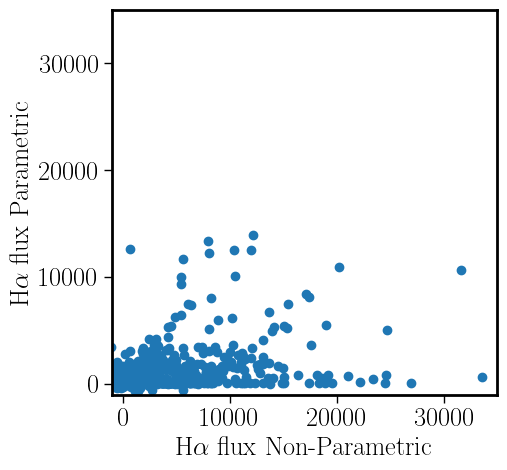

In [3]:
fig,ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(tab_DAP['flux_Halpha_6562.85'],tab_DAP['flux_pe_4861.32'])
ax.set_xlabel(r'H$\alpha$ flux Non-Parametric')
ax.set_ylabel(r'H$\alpha$ flux Parametric')
ax.set_aspect('equal', adjustable='box')
ax.set_xlim(-1000,35000)
ax.set_ylim(-1000,35000)
#plt.show()
#tab_DAP['flux_Halpha_6562.85','flux_pe_6562.68']

flux_st 3448.6533203125 182787680.0


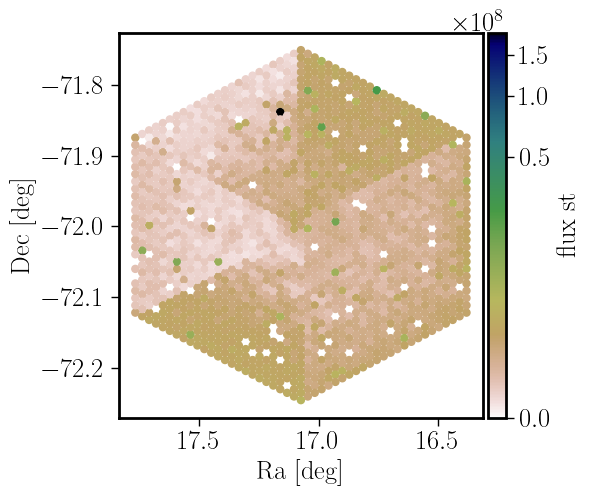

In [4]:
map_plot_DAP(tab_DAP,line='flux_st', \
                 vmin=0, vmax=0, title=None, filename='junk',\
             cmap='gist_earth_r', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')

flux_pe_4861.32 -664.6152 96217.4501


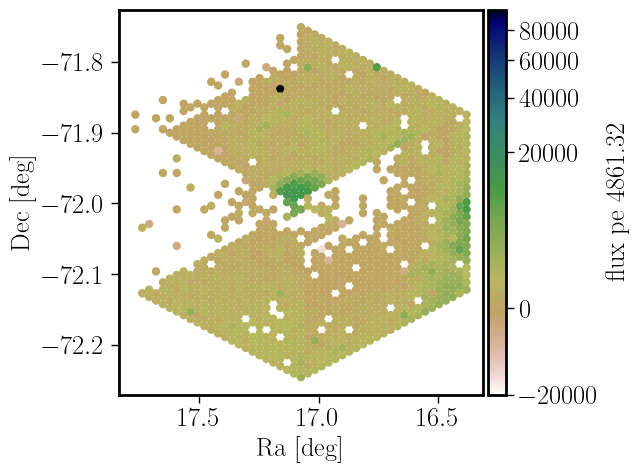

In [41]:
#tab_DAP['junk']=1.5*tab_DAP['flux_Halpha_6562.85']
map_plot_DAP(tab_DAP,line='flux_pe_4861.32', \
                 vmin=0, vmax=0, title=None, filename='junk',\
             cmap='gist_earth_r', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')

flux_Hbeta_4861.36 -2000 20000


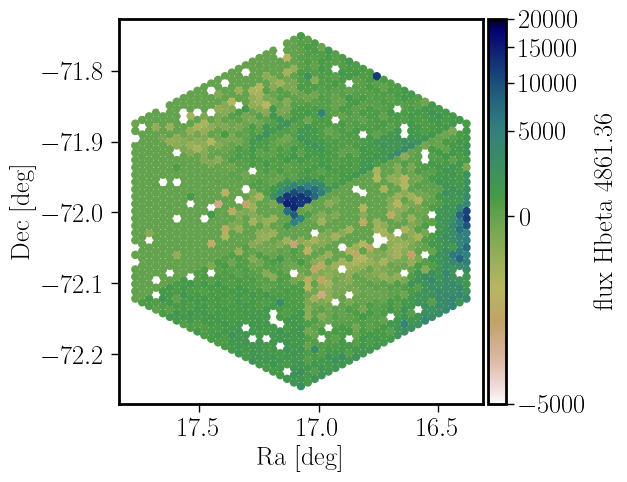

In [43]:
#tab_DAP['junk']=1.5*tab_DAP['flux_Halpha_6562.85']
map_plot_DAP(tab_DAP,line='flux_Hbeta_4861.36', \
                 vmin=-2000, vmax=20000, title=None, filename='junk',\
             cmap='gist_earth_r', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')

flux_Halpha_6562.85 -100 50000


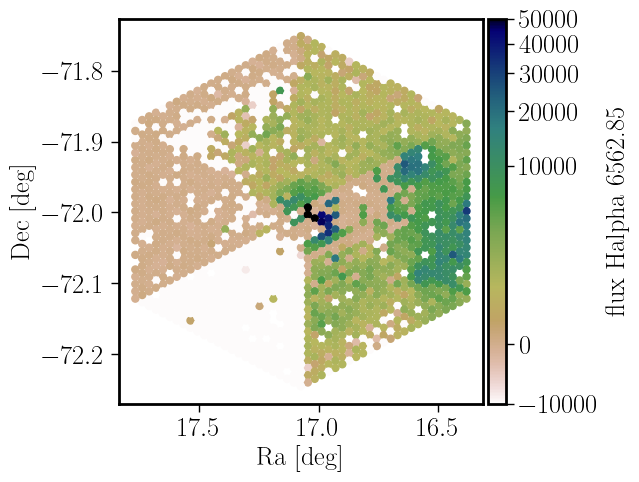

In [46]:
#tab_DAP['junk']=1.5*tab_DAP['flux_Halpha_6562.85']
map_plot_DAP(tab_DAP,line='flux_Halpha_6562.85', \
                 vmin=-100, vmax=50000, title=None, filename='junk',\
             cmap='gist_earth_r', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')

flux_pe_6562.68 -2932.9297 65290.8401


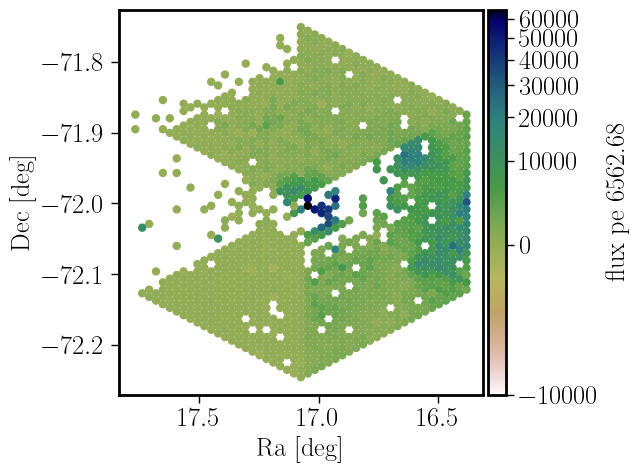

In [28]:
map_plot_DAP(tab_DAP,line='flux_pe_6562.68', \
                 vmin=0, vmax=0, title=None, filename='junk',\
             cmap='gist_earth_r', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')

flux_[SIII]_6312.06 -100 300


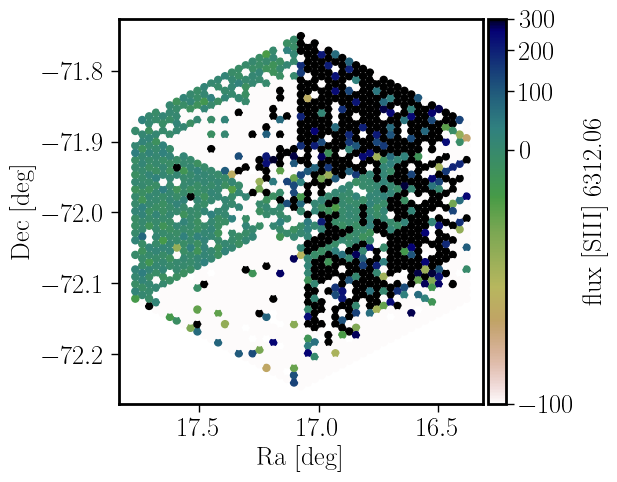

In [29]:
map_plot_DAP(tab_DAP,line='flux_[SIII]_6312.06', \
                 vmin=-100, vmax=300, title=None, filename='junk',\
             cmap='gist_earth_r', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')

flux_Hgamma_4340.49 -94680.3509697129 6415.428255508113


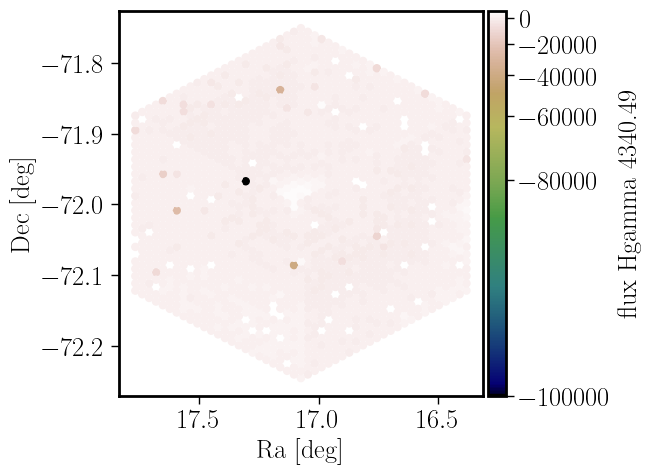

In [34]:
map_plot_DAP(tab_DAP,line='flux_Hgamma_4340.49',\
                 vmin=0, vmax=0, title=None, filename='junk',\
             cmap='gist_earth', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')

flux_Hgamma_4340.49 -150 1500


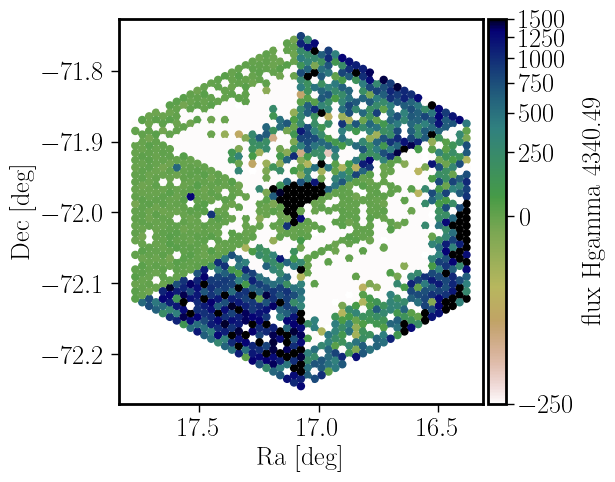

In [31]:
#flux_Hepsilon_3970.07'
#flux_Hdelta_4101.77',\
map_plot_DAP(tab_DAP,line='flux_Hgamma_4340.49',\
                 vmin=-150, vmax=1500, title=None, filename='junk',\
             cmap='gist_earth_r', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')

flux_[OIII]_4363.21 -150 500


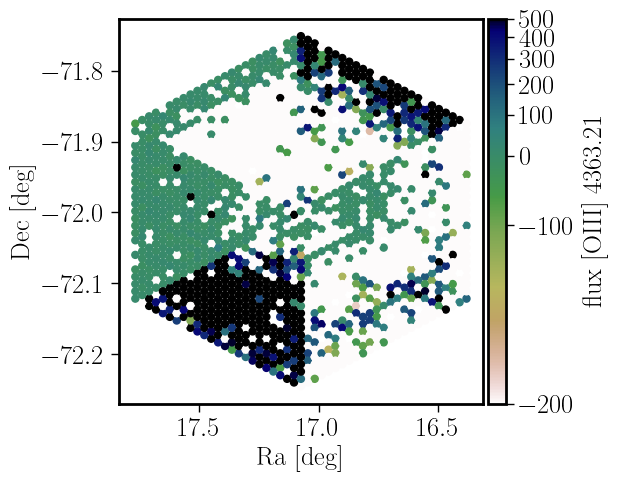

In [32]:
#flux_[OIII]_4363.21
map_plot_DAP(tab_DAP,line='flux_[OIII]_4363.21', \
                 vmin=-150, vmax=500, title=None, filename='junk',\
             cmap='gist_earth_r', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')

flux_[SIII]_6312.06 -89942.45940005624 30666.283419585292


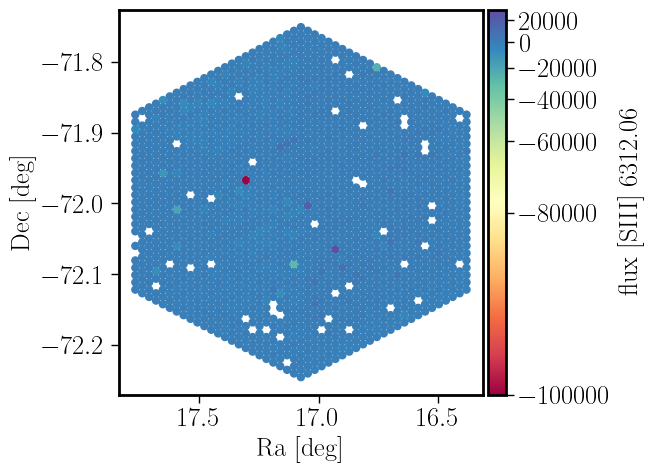

In [33]:
map_plot_DAP(tab_DAP,line='flux_[SIII]_6312.06', \
                 vmin=0, vmax=0, title=None, filename='junk',\
             cmap='Spectral', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')

flux_[NII]_5754.59 -106542.26541098018 4314.80620976184


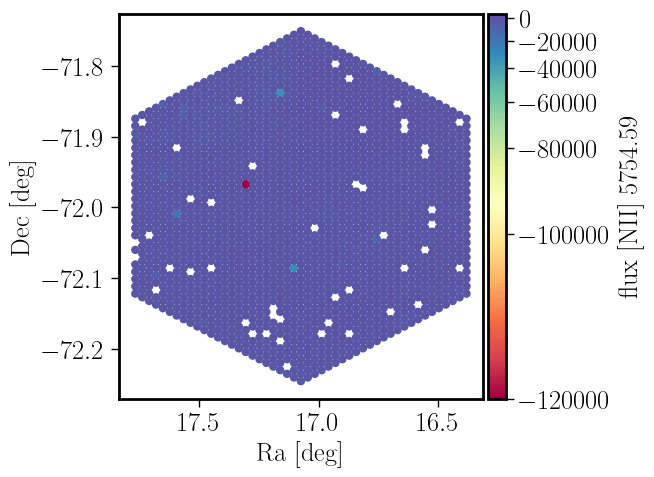

In [21]:
#[NII]_5754.59
map_plot_DAP(tab_DAP,line='flux_[NII]_5754.59', \
                 vmin=0, vmax=0, title=None, filename='junk',\
             cmap='Spectral', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')


flux_st 3448.6533203125 182787680.0


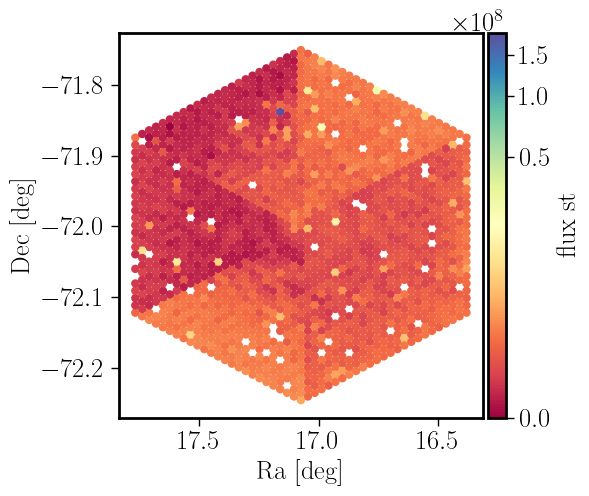

In [22]:
map_plot_DAP(tab_DAP,line='flux_st', \
                 vmin=0, vmax=0, title=None, filename='junk',\
             cmap='Spectral', fsize=5, figs_dir='figs',gamma=0.3,fig_type='pdf')

vel_Halpha_6562.85 -194.58581278965357 195.09803852327002


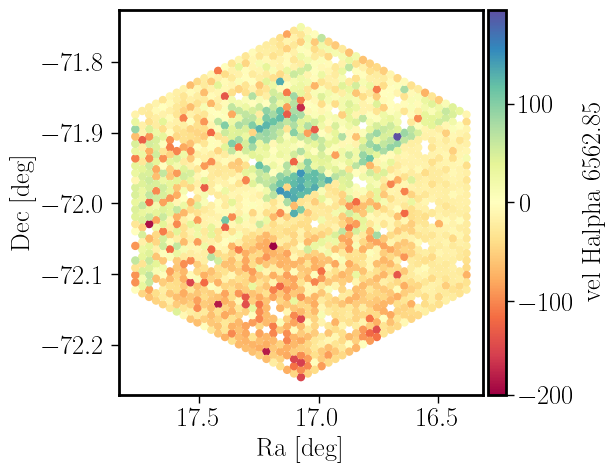

In [38]:
map_plot_DAP(tab_DAP,line='vel_Halpha_6562.85', \
                 vmin=0, vmax=0, title=None, filename='junk',\
             cmap='Spectral', fsize=5, figs_dir='figs',gamma=1.0)


Teff 3123.2533189870273 9622.809271769602


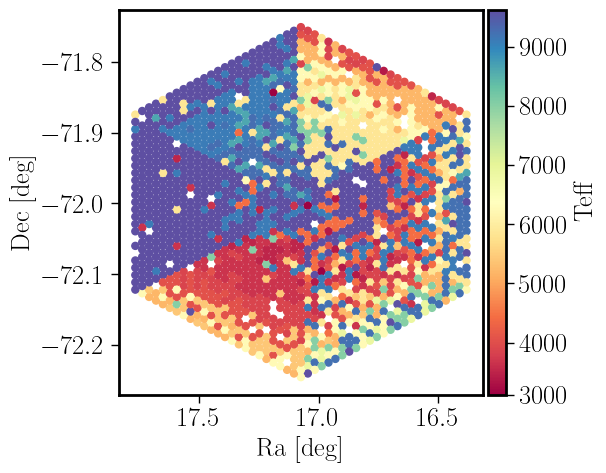

In [24]:
map_plot_DAP(tab_DAP,line='Teff', \
                 vmin=0, vmax=0, title=None, filename='junk',\
             cmap='Spectral', fsize=5, figs_dir='figs')


Fe -3.146961212158203 0.3858509957790375


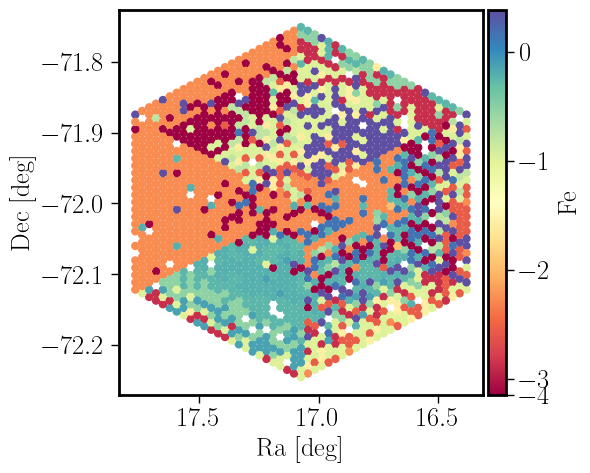

In [25]:
map_plot_DAP(tab_DAP,line='Fe', \
                 vmin=0, vmax=0, title=None, filename='junk',\
             cmap='Spectral', fsize=5, figs_dir='figs')
